# 1.Importação de bibliotecas

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

# 2. Carregamento da base

In [246]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', header=(0), index_col=0)


In [247]:
print(f"\nTamanho do dataset: {df.shape[0]} linhas e {df.shape[1]} colunas")
df.head(10)


Tamanho do dataset: 5110 linhas e 11 colunas


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB



Distribuição da variável alvo (stroke):
        count  percentual
stroke                   
0        4861   95.127202
1         249    4.872798


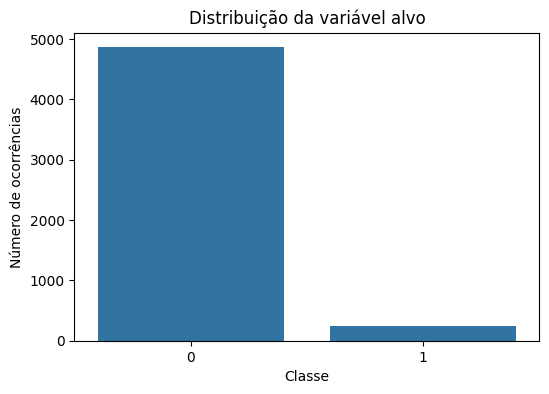

In [387]:
# Analise de Balanceamento
class_contagem = df['stroke'].value_counts()
class_percentual = df['stroke'].value_counts(normalize=True) * 100

print("\nDistribuição da variável alvo (stroke):")
print(pd.concat([class_contagem, class_percentual.rename("percentual")], axis=1))

# Visualização gráfica
plt.figure(figsize=(6,4))
sns.barplot(x=class_contagem.index, y=class_contagem.values)
plt.title("Distribuição da variável alvo")
plt.xlabel("Classe")
plt.ylabel("Número de ocorrências")
plt.show()



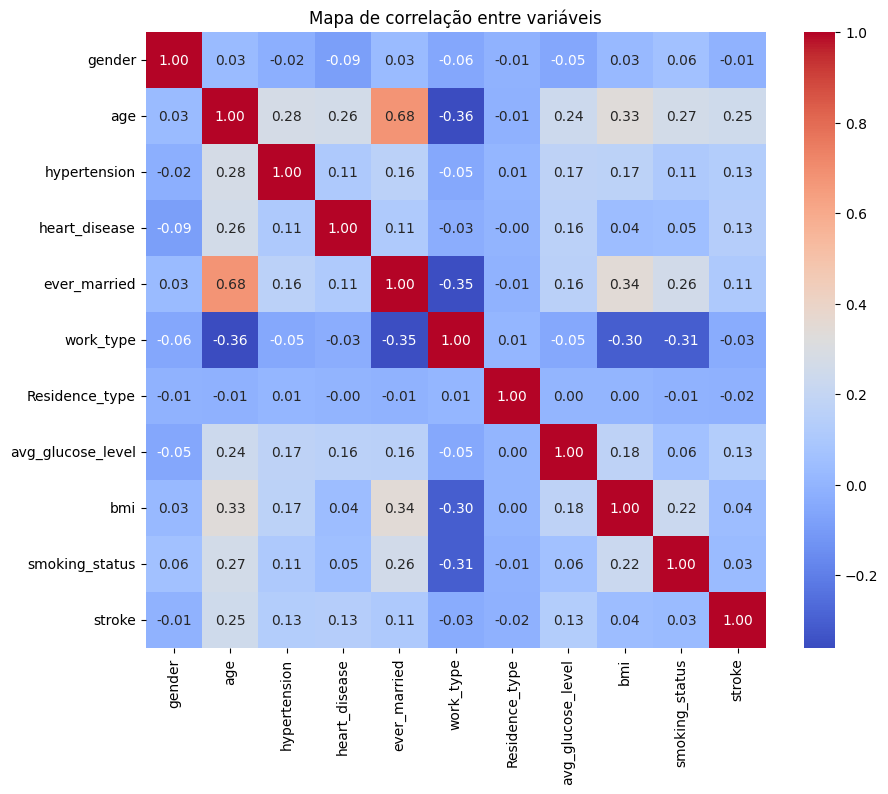

In [250]:
# Converter variáveis categóricas para numéricas temporariamente
df_corr = df.copy()
df_corr['gender'] = df_corr['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df_corr['ever_married'] = df_corr['ever_married'].map({'No': 0, 'Yes': 1})
df_corr['work_type'] = df_corr['work_type'].astype('category').cat.codes
df_corr['Residence_type'] = df_corr['Residence_type'].map({'Urban': 0, 'Rural': 1})
df_corr['smoking_status'] = df_corr['smoking_status'].astype('category').cat.codes

# Heatmap de correlação
plt.figure(figsize=(10,8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de correlação entre variáveis")
plt.show()


**Interpretação**

* Não foi identificada multicolinearidade alta entre as variáveis. Destace-se, entretanto, a correlação de age x ever_married

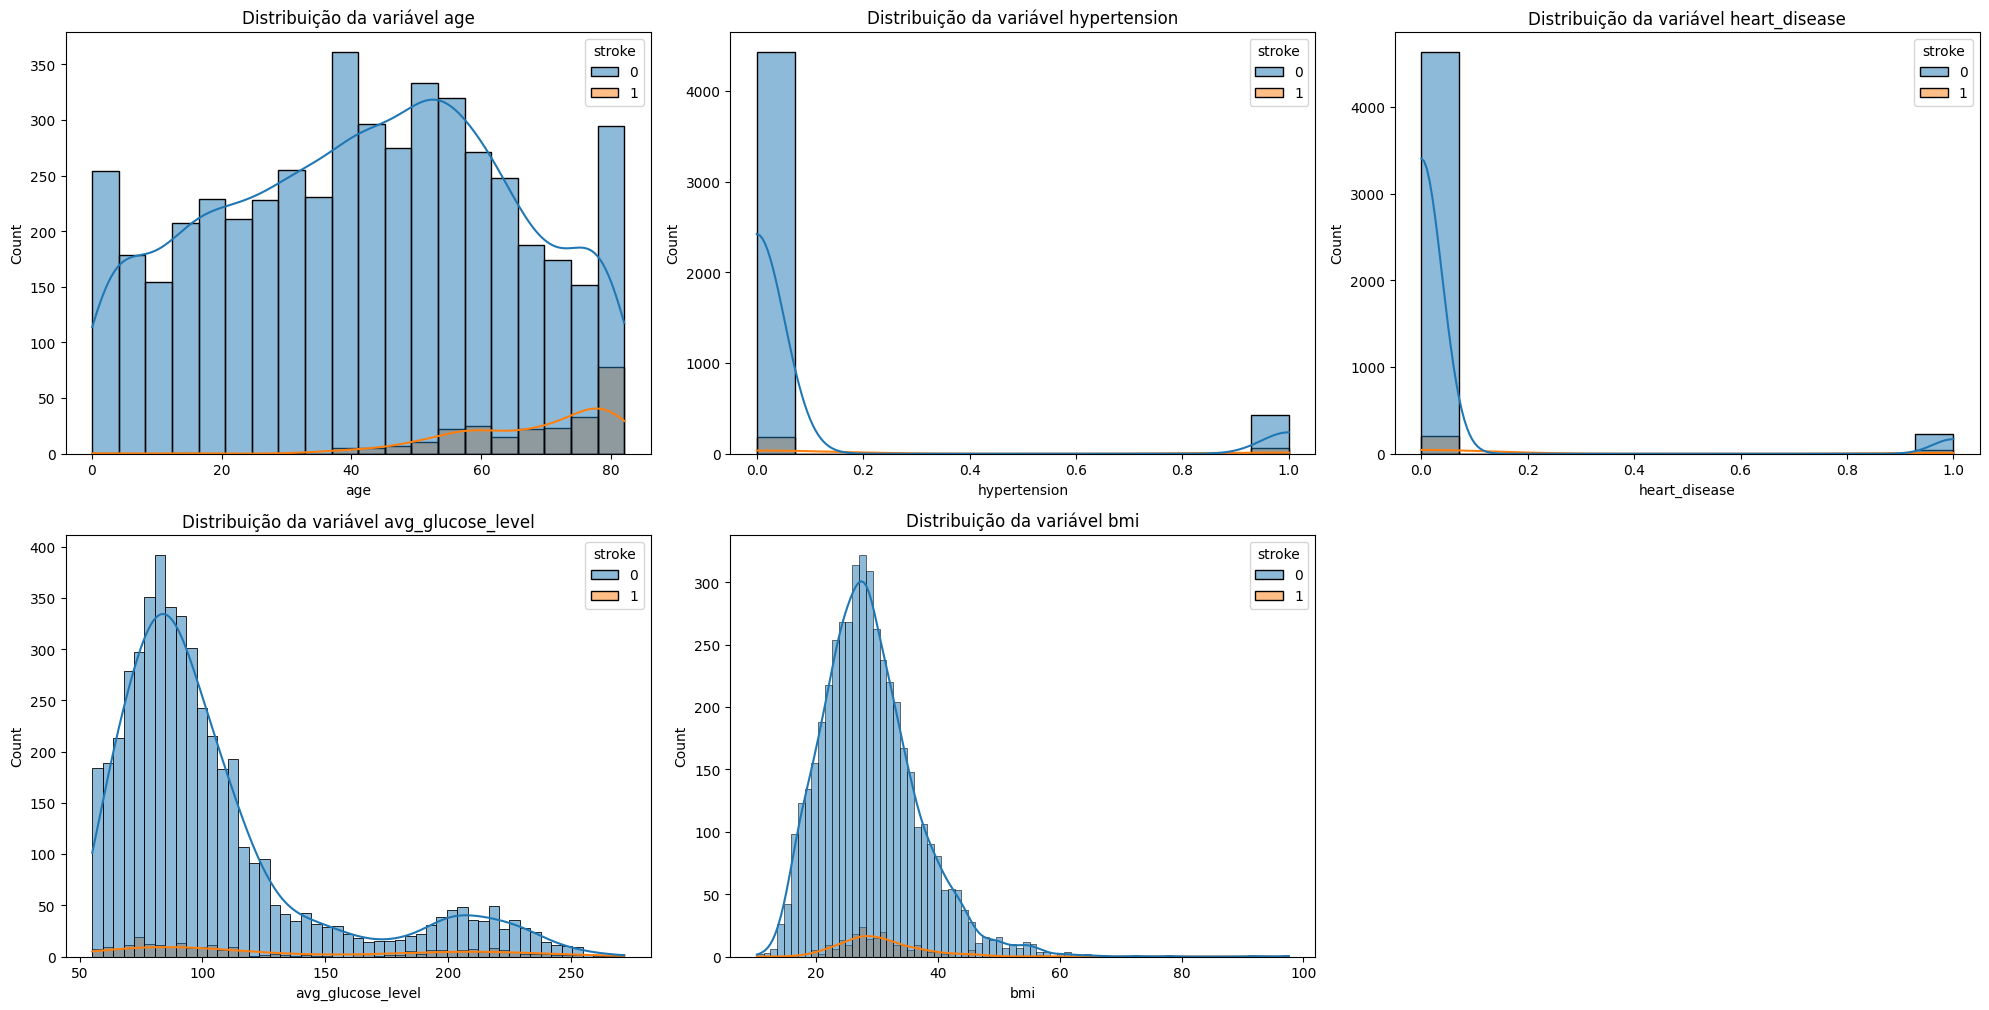

In [251]:
# Separar X (features) e y (alvo)
X = df.drop(columns=['stroke'])
y = df['stroke']

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Distribuições com relação ao Y
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))
axes = axes.flatten()

for i, coluna in enumerate(num_cols):
    sns.histplot(data=df, x=coluna, kde=True, hue=y, ax=axes[i])
    axes[i].set_title(f"Distribuição da variável {coluna}")

# Remove subplots não utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Interpretações**
* age: observa-se que a maioria dos casos de AVC ocorre em pacientes mais velhos. A distribuição para stroke=1 se desloca para a direita, indicando que a idade é um fator de risco importante.
* avg_glucose_level: pacientes com AVC tendem a apresentar níveis médios de glicose mais elevados, sugerindo associação com diabetes ou desregulação metabólica.
* bmi: há uma leve tendência de valores mais altos em pacientes com AVC.
* hypertension e heart_disease (binárias): a proporção de AVC é maior entre pacientes hipertensos e com histórico de doença cardíaca, reforçando o papel desses fatores de risco.


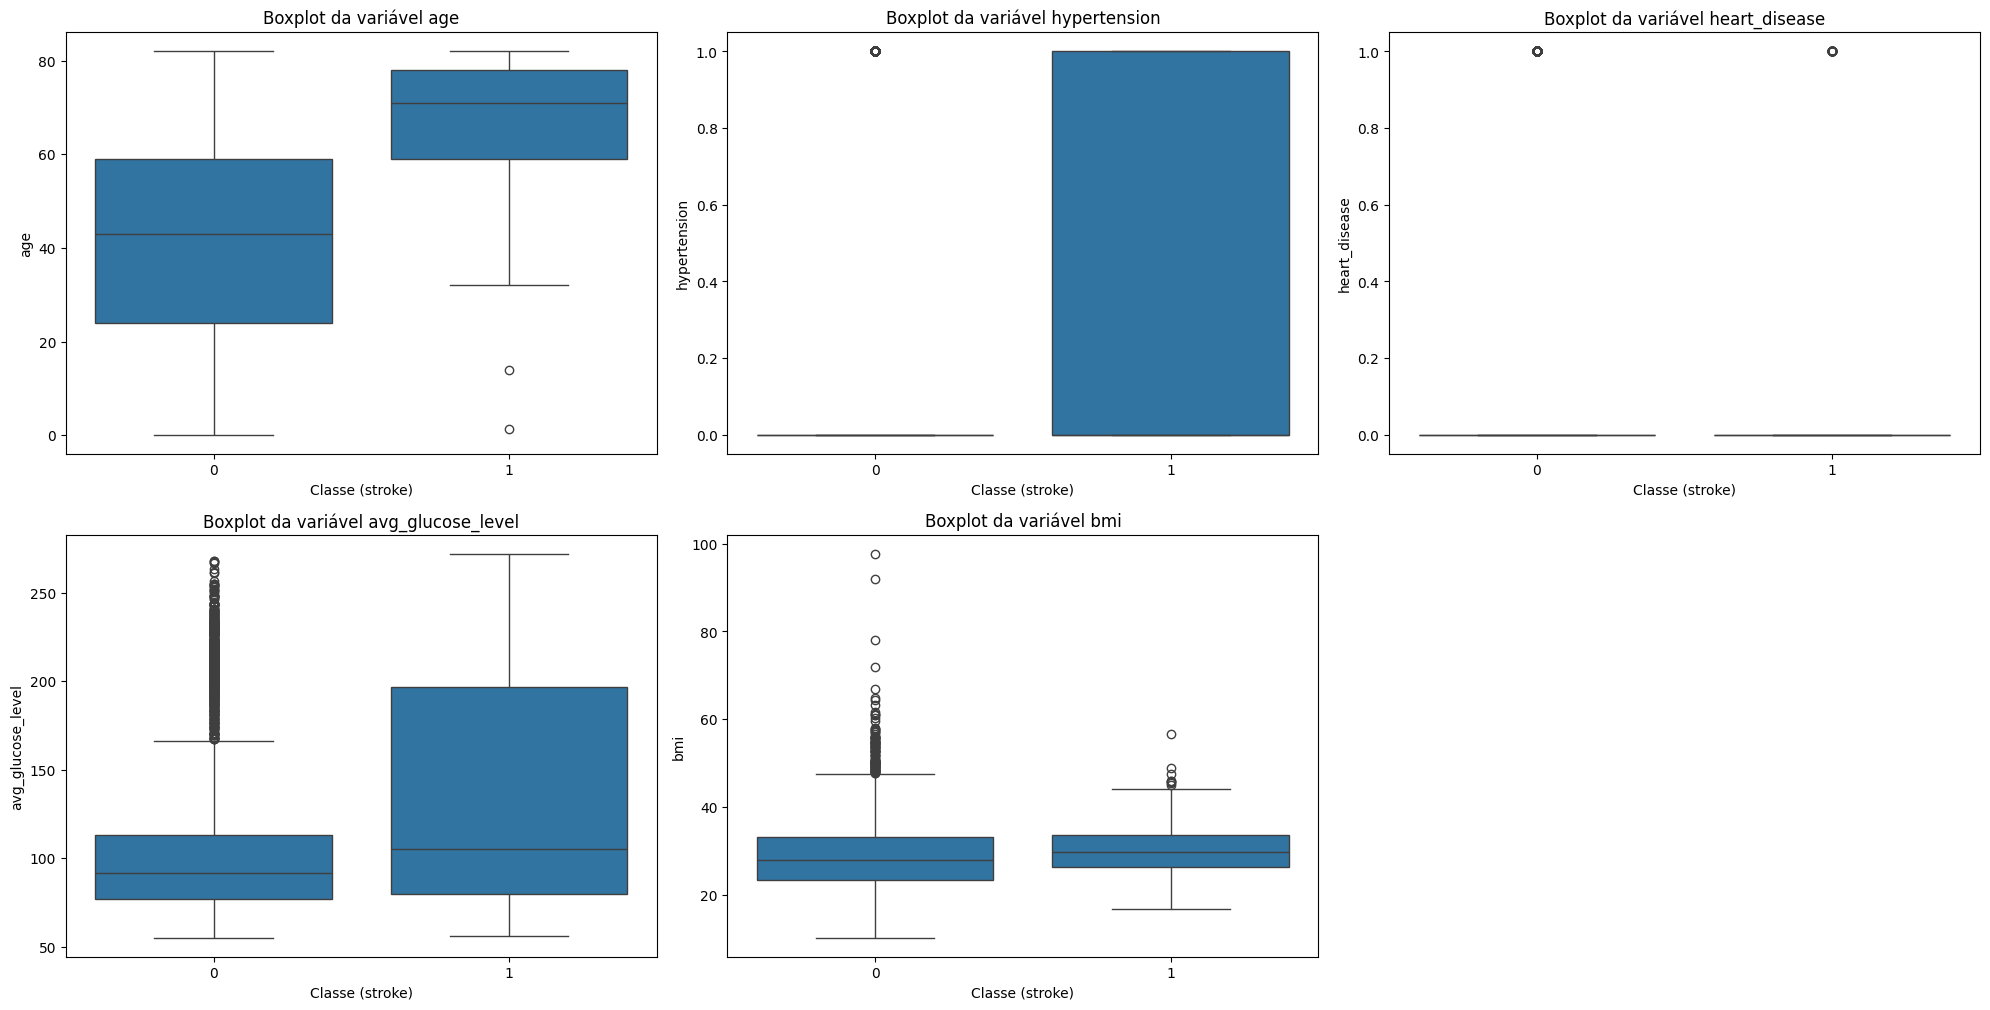

In [252]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))
axes = axes.flatten()

for i, coluna in enumerate(num_cols):
    sns.boxplot(x=y, y=X[coluna], ax=axes[i])
    axes[i].set_title(f"Boxplot da variável {coluna}")
    axes[i].set_xlabel("Classe (stroke)")
    axes[i].set_ylabel(coluna)

# Remove subplots não utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Interpretação**
* Identificação de outliers em avg_glucose_level e bmi

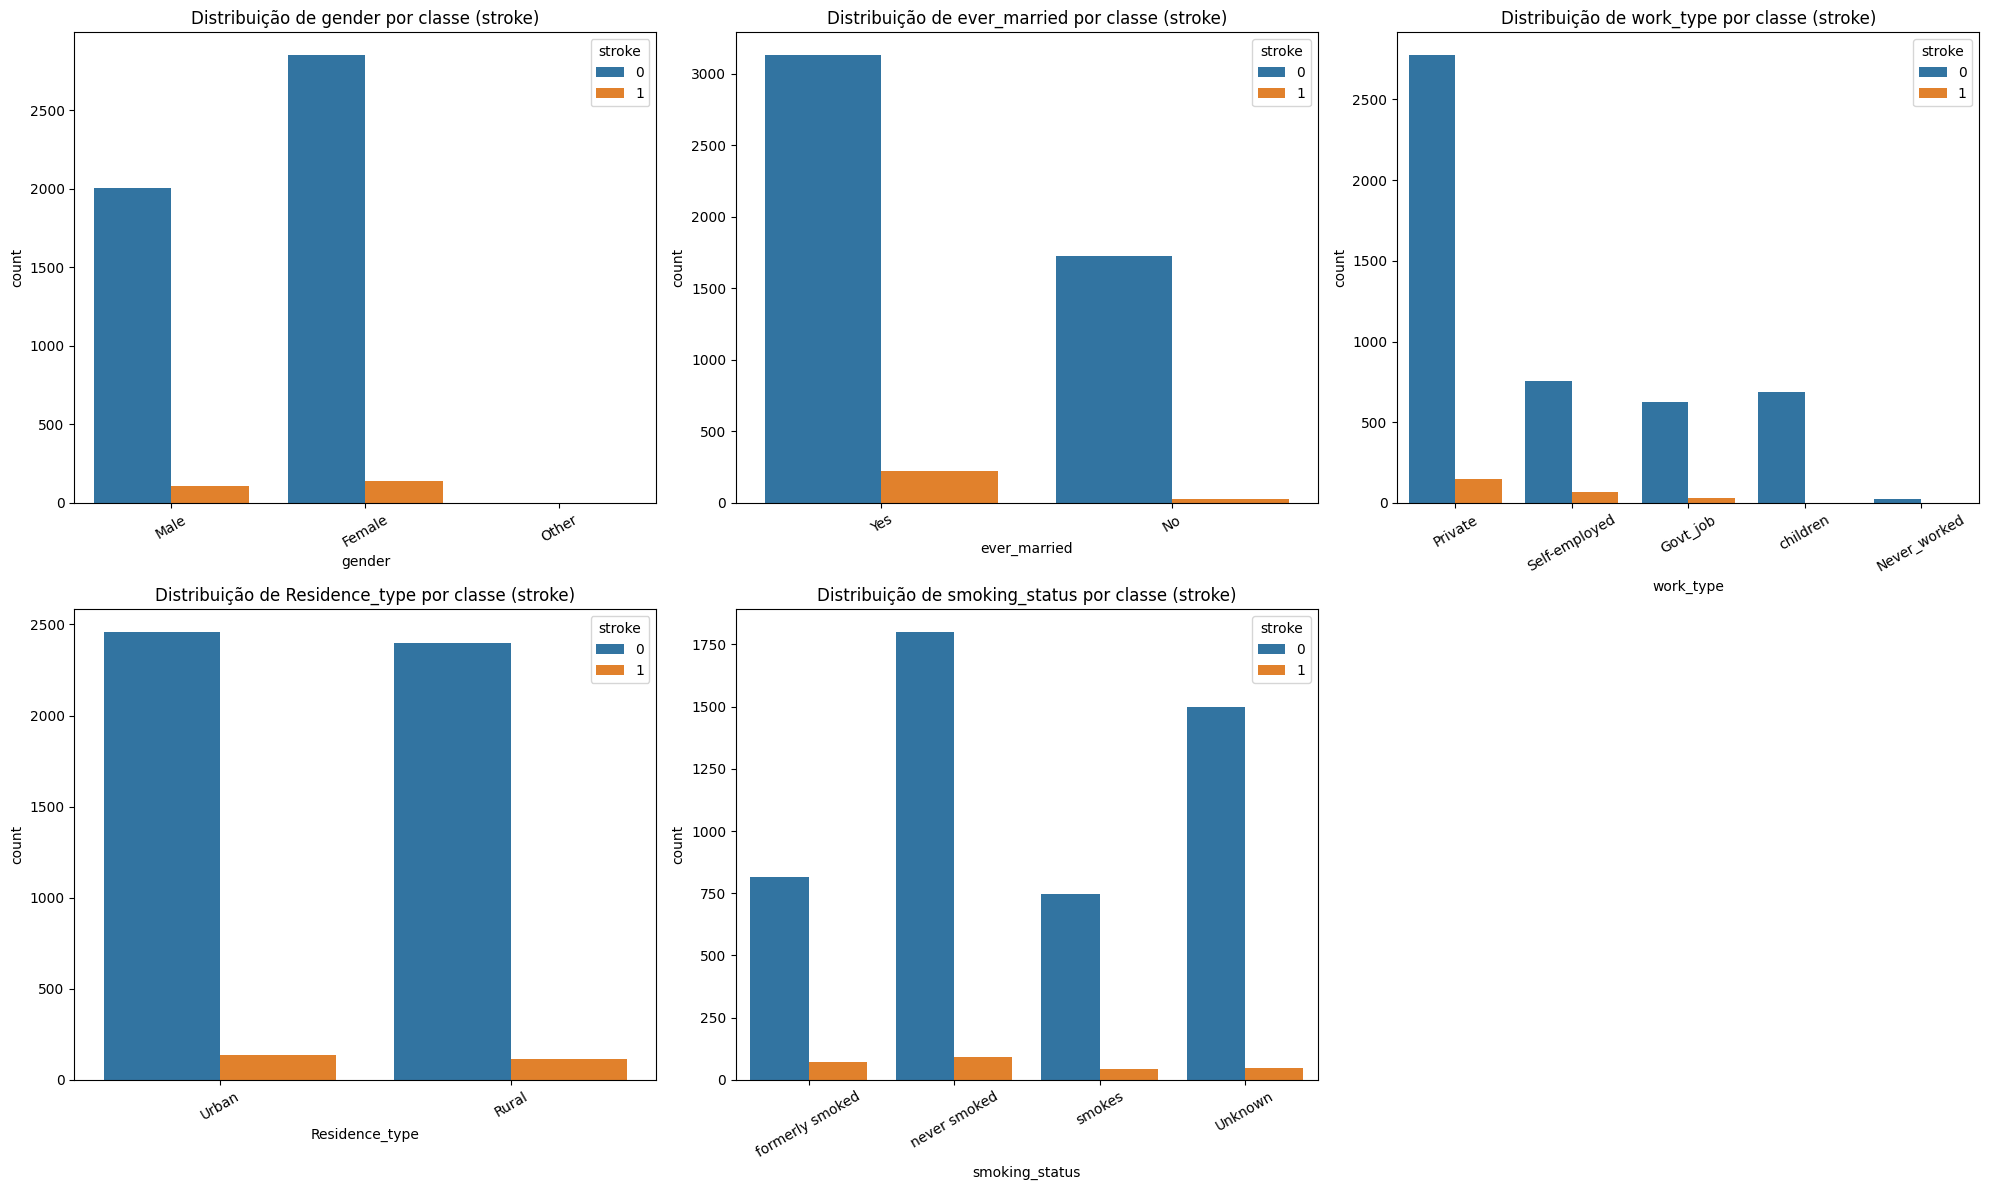

In [253]:
# Countplots para variáveis categóricas em relação ao stroke

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue='stroke', ax=axes[i])
    axes[i].set_title(f"Distribuição de {col} por classe (stroke)")
    axes[i].tick_params(axis='x', rotation=30)

# Remove subplots não usados
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



*   Não há aparente relação entre as variáveis acima e casos de AVC.





In [254]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Verificar valores 'estranhos' (NaN, infinitos)
print("\nValores NaN:")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

# Identificar variáveis categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print("\nVariáveis categóricas:")
print(list(cat_cols))

# Resumo estatístico das numéricas
print("\nResumo estatístico das variáveis numéricas:")
print(df.describe())


Valores ausentes por coluna:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Valores NaN:
age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

Variáveis categóricas:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Resumo estatístico das variáveis numéricas:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000     

**Interpretação**
* Existem 201 ausentes na variável bmi.
* Não foi constatada a presença de valores NaN.
* Foram identificadas 5 variáveis categórica que precisaram de tratamento.

# 3. Pré-procesamento

In [256]:
dataset = pd.DataFrame(df)

train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

train_data
test_data

X_train, y_train = train_data.drop(['stroke'], axis=1), train_data['stroke']
X_test, y_test = test_data.drop(['stroke'], axis=1), test_data['stroke']

In [257]:
# Identifica tipo dos features

colunas_numericas = ['age', 'avg_glucose_level', 'bmi']
colunas_categoricas = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
colunas_binarias = ['hypertension', 'heart_disease']

#Pipeline para colunas numéricas

pipeline_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipline para as colunas categóricas

pipeline_categoricas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#aplicar o columnTransformer

preprocessador = ColumnTransformer(transformers=[
    ('num', pipeline_numericas, colunas_numericas + colunas_binarias),
    ('cat', pipeline_categoricas, colunas_categoricas)
])

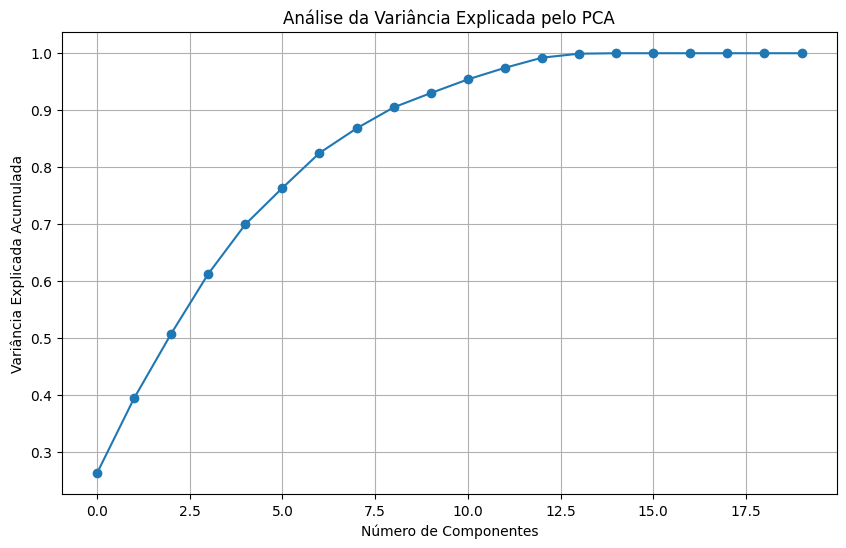

In [258]:
# Aplicando apenas o pré-processamento (sem SMOTE nem PCA)
X_train_pre = preprocessador.fit_transform(X_train)
X_test_pre = preprocessador.transform(X_test)

# Aplicando PCA para todos os componentes

pca_teste = PCA()
pca_teste.fit(X_train_pre)

# Variância explicada acumulada


plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca_teste.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Análise da Variância Explicada pelo PCA')
plt.grid(True)
plt.show()


A análise da variância explicada pelo PCA mostrou que os 10 primeiros features principais são suficientes para capturar mais de 100% da variância dos dados, pois a curva gerada apresenta estabilização a partir do décimo primeiro componente, mostrando que os adicionais não agregam significativamente.
Diante disto, optou-se por utilizar 11 componentes.


In [259]:
# Realizando o balaceamento das classes

smote = SMOTE(random_state=42)

In [260]:
# reduzindo a dimensionalidade

pca = PCA(n_components=11)

In [261]:
# 1. Aplicar o pré-processamento
X_train_proc = preprocessador.fit_transform(X_train)
X_test_proc = preprocessador.transform(X_test)

# 2. Aplicar o SMOTE
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)

# 3. Aplicar o PCA
X_train_final = pca.fit_transform(X_train_bal)
X_test_final = pca.transform(X_test_proc)


In [386]:
print("Formato original:", train_data.shape)
print("Formato após pré-processamento:", X_train_final.shape)

Formato original: (3832, 11)
Formato após pré-processamento: (7326, 11)


# 5. Treinamento e Avaliação de Modelos

In [300]:
resultados = {
    "Algoritmo":[],
    "Parametrização": [],
    "Acuracia": [],
    "Recall": [],
    "Roc_auc": [],
    "F1_score":[]
}

In [302]:
def avaliar_modelos_cv(tipo, parametrizacoes, X, y, resultados, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for nome_param, modelo in parametrizacoes.items():
        print("Avaliando", tipo, "com parametrização:", nome_param)

        accs, recalls, aucs,f1s = [], [], [],[]

        for train_idx, val_idx in skf.split(X, y):
            X_treino, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_treino, y_val = y.iloc[train_idx], y.iloc[val_idx]

            modelo.fit(X_treino, y_treino)
            y_pred = modelo.predict(X_val)
            y_score = modelo.predict_proba(X_val)[:, 1]

            accs.append(accuracy_score(y_val, y_pred))
            recalls.append(recall_score(y_val, y_pred))
            aucs.append(roc_auc_score(y_val, y_score))
            f1s.append(f1_score(y_val, y_pred))


        resultados["Algoritmo"].append(tipo)
        resultados["Parametrização"].append(nome_param)
        resultados["Acuracia"].append(np.mean(accs))
        resultados["Recall"].append(np.mean(recalls))
        resultados["Roc_auc"].append(np.mean(aucs))
        resultados["F1_score"].append(np.mean(f1s))



In [304]:
# Modelo KNN
modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11)
}

avaliar_modelos_cv("KNN", modelos_knn, pd.DataFrame(X_train_final), pd.Series(y_train_bal), resultados)

Avaliando KNN com parametrização: N=3
Avaliando KNN com parametrização: N=5
Avaliando KNN com parametrização: N=7
Avaliando KNN com parametrização: N=9
Avaliando KNN com parametrização: N=11


In [305]:
# Random Forest

modelos_rf = {
    "N=100": RandomForestClassifier(n_estimators=100),
    "N=200": RandomForestClassifier(n_estimators=200),
    "N=300": RandomForestClassifier(n_estimators=300)
}

avaliar_modelos_cv("RandomForest", modelos_rf, pd.DataFrame(X_train_final), pd.Series(y_train_bal), resultados)

Avaliando RandomForest com parametrização: N=100
Avaliando RandomForest com parametrização: N=200
Avaliando RandomForest com parametrização: N=300


In [306]:
#XGBoost

modelos_xgb = {
    "Default": XGBClassifier(eval_metric='logloss'),
    "Depth 3": XGBClassifier(max_depth=3, eval_metric='logloss')
}

avaliar_modelos_cv("XGBoost", modelos_xgb, pd.DataFrame(X_train_final), pd.Series(y_train_bal), resultados)


Avaliando XGBoost com parametrização: Default
Avaliando XGBoost com parametrização: Depth 3


In [307]:
# SVM

modelos_svm = {
    "Linear": SVC(kernel='linear', probability=True),
    "RBF": SVC(kernel='rbf', gamma='scale', probability=True),
    "Sigmoide": SVC(kernel = 'sigmoid', probability=True),
    "Poly grau 2": SVC(kernel='poly', degree=2, probability=True)
}

avaliar_modelos_cv("SVM", modelos_svm, pd.DataFrame(X_train_final), pd.Series(y_train_bal), resultados)


Avaliando SVM com parametrização: Linear
Avaliando SVM com parametrização: RBF
Avaliando SVM com parametrização: Sigmoide
Avaliando SVM com parametrização: Poly grau 2


# 6. Otimização de modelos

In [308]:
# Dataframe com os resultados dos modelos rodados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Roc_auc,F1_score
0,KNN,N=3,0.927520,0.993723,0.960387,0.932066
1,KNN,N=5,0.910320,0.992903,0.963012,0.917185
2,KNN,N=7,0.897899,0.993996,0.964031,0.906894
3,KNN,N=9,0.887115,0.993176,0.963419,0.897970
4,KNN,N=11,0.879335,0.993176,0.961985,0.891706
5,RandomForest,N=100,0.954136,0.982258,0.991434,0.955433
6,RandomForest,N=200,0.954682,0.982804,0.991946,0.955952
7,RandomForest,N=300,0.953454,0.982531,0.992026,0.954814
8,XGBoost,Default,0.948677,0.983349,0.989065,0.950469
9,XGBoost,Depth 3,0.910866,0.959597,0.966337,0.915040


In [322]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["F1_score"].agg([ ("F1_score", max) ])
best_roc_aucs



/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  if (await self.run_code(code, result,  async_=asy)):


,F1_score
Algoritmo,
KNN,0.932066
RandomForest,0.955952
SVM,0.880225
XGBoost,0.950469


Identificado RandomForest como o melhor modelo, considerando F1_Score e Acurácia, que será direcionado para a otimização.

In [325]:
# parâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid_rf,
    cv=5,
    scoring='f1'
)

# Treinando com os dados finais
grid_rf.fit(X_train_final, y_train_bal)

# Melhor modelo
melhor_rf = grid_rf.best_estimator_



Melhor configuração RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Melhor F1-score RF: 0.9537783000177523


In [342]:
# GridSearch SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid_svm,
    cv=5,
    scoring='f1'
)
grid_svm.fit(X_train_final, y_train_bal)
melhor_svm = grid_svm.best_estimator_

Foram escolhidos RBF e Linear pelo melhor desempenho apresentado anteriormente.

In [344]:
# GridSearch KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='f1'
)
grid_knn.fit(X_train_final, y_train_bal)
melhor_knn = grid_knn.best_estimator_

In [346]:
#GridSearch XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, 5, 10]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_grid_xgb,
    cv=5,
    scoring='f1'
)
grid_xgb.fit(X_train_final, y_train_bal)
melhor_xgb = grid_xgb.best_estimator_

# 7. Avaliação de Modelo


In [381]:
def avaliar_modelo(modelo, nome, X_test_data, y_test_data):
    y_pred = modelo.predict(X_test_data)

    cm = confusion_matrix(y_test, y_pred)

    # Plotando com seaborn
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem AVC', 'Com AVC'], yticklabels=['Sem AVC', 'Com AVC'])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {nome} Otimizado')
    plt.show()

    print(f"\n Avaliação do modelo: {nome}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))


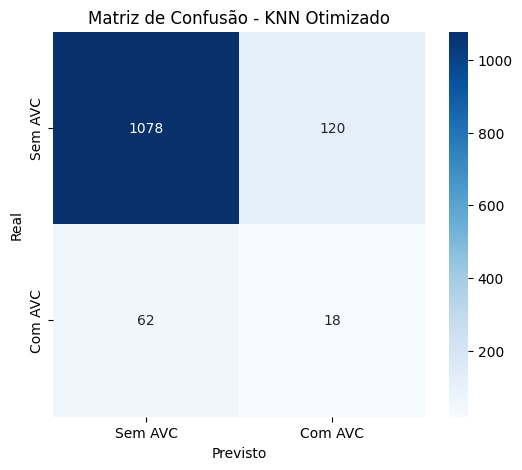


 Avaliação do modelo: KNN
[[1078  120]
 [  62   18]]
              precision    recall  f1-score   support

           0     0.9456    0.8998    0.9222      1198
           1     0.1304    0.2250    0.1651        80

    accuracy                         0.8576      1278
   macro avg     0.5380    0.5624    0.5436      1278
weighted avg     0.8946    0.8576    0.8748      1278



In [382]:
#Matriz de confusão KNN
avaliar_modelo(melhor_knn, "KNN", X_test_final, y_test)

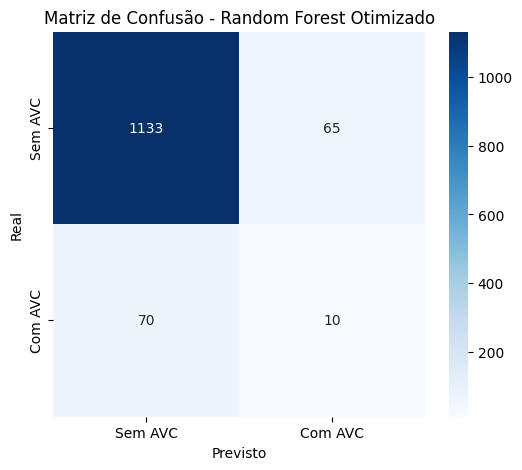


 Avaliação do modelo: Random Forest
[[1133   65]
 [  70   10]]
              precision    recall  f1-score   support

           0     0.9418    0.9457    0.9438      1198
           1     0.1333    0.1250    0.1290        80

    accuracy                         0.8944      1278
   macro avg     0.5376    0.5354    0.5364      1278
weighted avg     0.8912    0.8944    0.8928      1278



In [383]:
#Matriz de confusão Random Forest
avaliar_modelo(melhor_rf, "Random Forest", X_test_final, y_test)

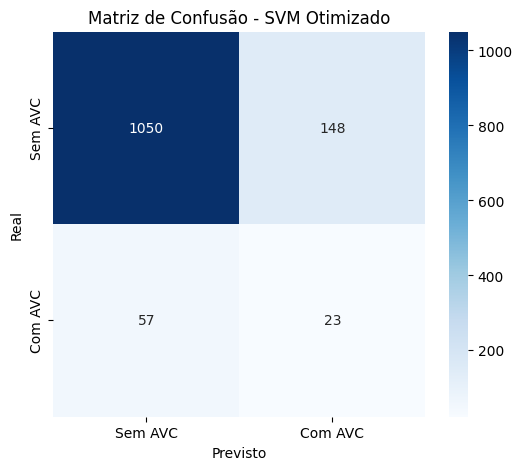


 Avaliação do modelo: SVM
[[1050  148]
 [  57   23]]
              precision    recall  f1-score   support

           0     0.9485    0.8765    0.9111      1198
           1     0.1345    0.2875    0.1833        80

    accuracy                         0.8396      1278
   macro avg     0.5415    0.5820    0.5472      1278
weighted avg     0.8976    0.8396    0.8655      1278



In [384]:
#Matriz de confusão SVM
avaliar_modelo(melhor_svm, "SVM", X_test_final, y_test)

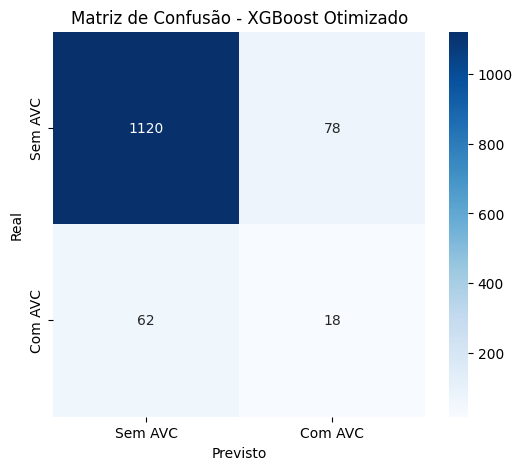


 Avaliação do modelo: XGBoost
[[1120   78]
 [  62   18]]
              precision    recall  f1-score   support

           0     0.9475    0.9349    0.9412      1198
           1     0.1875    0.2250    0.2045        80

    accuracy                         0.8905      1278
   macro avg     0.5675    0.5799    0.5729      1278
weighted avg     0.9000    0.8905    0.8951      1278



In [385]:
#Matriz de confusão XGBoost
avaliar_modelo(melhor_xgb, "XGBoost", X_test_final, y_test)

# 8. Comparativo de Performance

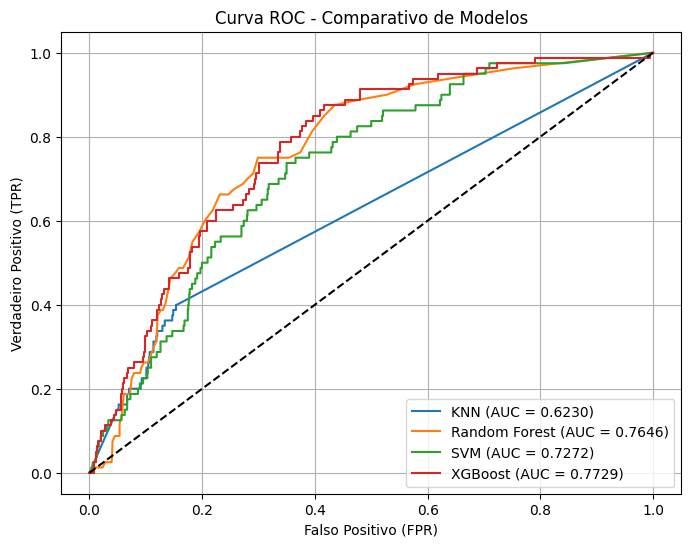

In [356]:


def plotar_roc(modelo, nome, X_test_data, y_test_data):
    y_proba = modelo.predict_proba(X_test_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_data, y_proba)
    auc = roc_auc_score(y_test_data, y_proba)
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc:.4f})')

plt.figure(figsize=(8,6))
plotar_roc(melhor_knn, "KNN", X_test_final, y_test)
plotar_roc(melhor_rf, "Random Forest", X_test_final, y_test)
plotar_roc(melhor_svm, "SVM", X_test_final, y_test)
plotar_roc(melhor_xgb, "XGBoost", X_test_final, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title('Curva ROC - Comparativo de Modelos')
plt.legend()
plt.grid(True)
plt.show()

Após a comparação dos quatro modelos diferentes, fois possível perceber que o maior problema está na identificação da classe minoritária, muito provavelmente pela característica de alto desbalancemento que o dataset apresenta.
Ao observar a curva ROC, percebemos que o modelo que se destacou de forma geral foi o XGBoost.